In [42]:
#Loading all the needed packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [43]:
#Reading in the house prices data
houseprices=pd.read_excel("https://www.dropbox.com/scl/fi/wo1xekb38dop4ghogwov7/houseprices.xlsx?rlkey=smy3927t84f22fx53azwnemtv&st=g0nr5bm6&dl=1")
#Reading in additional interest rate data
interestRates=pd.read_excel("https://www.dropbox.com/scl/fi/2ophcyb84usnlor9ovoa8/interestRates.xlsx?rlkey=y12lyd60l0mznbu74sjlotw2e&st=26ymo7a4&dl=1")

#Taking the avg interest rate by Year
interestRates=interestRates.groupby("Year")["Effective Federal Funds Rate"].mean().reset_index()
interestRates=interestRates[["Year","Effective Federal Funds Rate"]]

#Merge in the interest rate data, joining on year
df=houseprices.merge(interestRates,how="left", left_on="yrsold", right_on="Year")

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,Year,Effective Federal Funds Rate
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,2008,1.927500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,2007,5.019167
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,2008,1.927500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,2006,4.964167
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,2008,1.927500


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1460 non-null   int64  
 1   mssubclass                    1460 non-null   int64  
 2   mszoning                      1460 non-null   object 
 3   lotfrontage                   1201 non-null   float64
 4   lotarea                       1460 non-null   int64  
 5   street                        1460 non-null   object 
 6   alley                         91 non-null     object 
 7   lotshape                      1460 non-null   object 
 8   landcontour                   1460 non-null   object 
 9   utilities                     1460 non-null   object 
 10  lotconfig                     1460 non-null   object 
 11  landslope                     1460 non-null   object 
 12  neighborhood                  1460 non-null   object 
 13  con

In [45]:
#In this step we are executing some data wrangling using knowledge from prior experience with this dataset

#Creating a new Age column which is year sold minus year built
df["Age"]=df.Year-df.yearbuilt

#As the below columns have a very large number of missing rows, we will eliminate them. Other techniques like interpolation aren't good candidates with this much missing data
df.drop(columns=["id","garageyrblt","lotfrontage","alley","masvnrtype","fireplacequ","poolqc","fence","miscfeature","mosold","yrsold","Year","yearbuilt"], inplace=True)

#Drop the small number of remaining rows which have null values. We could fill in missing data with means or interpolation but a large number of th emissing values are also categorical
df.dropna(inplace=True)

In [46]:
column_list=[]

#create a correlation matrix between saleprice and every numeric column
for column in df.select_dtypes(include=['int64', 'float64']):
    df_subset = df[['saleprice', column]].copy()
    df_subset = df_subset.apply(pd.to_numeric, errors='coerce') #require as there is some junk data in a few cells
    correlation_matrix = df_subset.corr()
    if (abs(correlation_matrix.iloc[0, 1])>.6 or column=="Age" or column=="Effective Federal Funds Rate"): #select any columns which have a correlation value >.6 with saleprice as siomplistic means of getting baseline features
      column_list.append(column)

columns_to_drop=list(set(df.select_dtypes(include=['int64', 'float64']).columns)-set(column_list)) #subtract the correlated columns from all numeric columns

df.drop(columns=columns_to_drop, inplace=True) #and drop those remaining numeric columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mszoning                      1338 non-null   object 
 1   street                        1338 non-null   object 
 2   lotshape                      1338 non-null   object 
 3   landcontour                   1338 non-null   object 
 4   utilities                     1338 non-null   object 
 5   lotconfig                     1338 non-null   object 
 6   landslope                     1338 non-null   object 
 7   neighborhood                  1338 non-null   object 
 8   condition1                    1338 non-null   object 
 9   condition2                    1338 non-null   object 
 10  bldgtype                      1338 non-null   object 
 11  housestyle                    1338 non-null   object 
 12  overallqual                   1338 non-null   int64  
 13  roofstyl

In [47]:
object_columns = df.select_dtypes(include='object').columns.tolist()

#create a dataframe for each categorical variable along with saleprice
dfs = {}
for col in object_columns:
    grouped = df.groupby(col)['saleprice']
    std_dev=grouped.std()
    if std_dev.mean()>80000: #select those columns with  a high standard deviation as a simplistic means of feature selection
      dfs[col] = grouped

include_cols=[]

for col, df_grouped in dfs.items():
    include_cols.append(col) #gather the columns to keep

columns_to_drop=list(set(object_columns)-set(include_cols)) #and subtract them from the full set of categorical columns

df.drop(columns=columns_to_drop, inplace=True) #then drop those not selected

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lotshape                      1338 non-null   object 
 1   landslope                     1338 non-null   object 
 2   overallqual                   1338 non-null   int64  
 3   roofmatl                      1338 non-null   object 
 4   bsmtexposure                  1338 non-null   object 
 5   totalbsmtsf                   1338 non-null   int64  
 6   firstflrsf                    1338 non-null   int64  
 7   grlivarea                     1338 non-null   int64  
 8   garagecars                    1338 non-null   int64  
 9   garagearea                    1338 non-null   int64  
 10  garagequal                    1338 non-null   object 
 11  saletype                      1338 non-null   object 
 12  salecondition                 1338 non-null   object 
 13  salepric

In [48]:
#map categorical values to numeric values
for col in df.select_dtypes(include='object').columns:
  col_vals=df[col].unique()
  mapping_dict = {val: idx + 1 for idx, val in enumerate(col_vals)}
  df[col]=df[col].map(mapping_dict)

At this point we have a feather set selected by some very basic reasoning.
The plan will be to run one OLS Linear Regresison model to see if the model is better than random chance (P value less than .05) and to see if we can determine any features that don;t provide value (again we will bse this purely on P value).

In [49]:
X=df.drop(columns="saleprice")
y=df["saleprice"]

#create a training set of 80% and a test set of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train=sm.add_constant(X_train)

results=sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     242.9
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:01:37   Log-Likelihood:                -12722.
No. Observations:                1070   AIC:                         2.548e+04
Df Residuals:                    1054   BIC:                         2.556e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

The features totalbsmtsf, garagearea, garagequal, saletype, and salecondition seem to not be contributing. We will try without them to see if we get any improvment.

In [50]:
X=df.drop(columns=["saleprice","totalbsmtsf","garagearea","garagequal","saletype","salecondition"])
y=df["saleprice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train=sm.add_constant(X_train)

results=sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     364.1
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:01:38   Log-Likelihood:                -12724.
No. Observations:                1070   AIC:                         2.547e+04
Df Residuals:                    1059   BIC:                         2.552e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

THis model is slightly better based on the F-statistic, which is valid comparison given that this model is a subset of features of the previous model.

We will now do 5-fold cross validation using OLS, Lasso, Ridge, and ElasticNet. Based on which one has the best R-Squared, we will use that model to make predicitons.

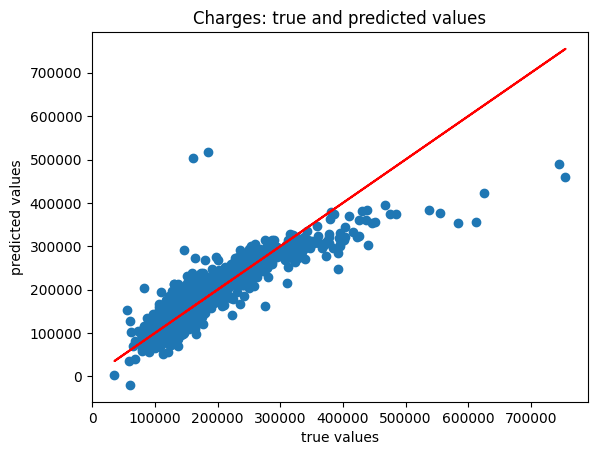

Average R-squared from cross-validation: 0.7730452752705066


In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)

r_squared_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    results = sm.OLS(y_train, X_train).fit()

    r_squared = results.rsquared
    r_squared_values.append(r_squared)

y_train_pred=results.predict(X_train)

plt.scatter(y_train, y_train_pred)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

mean_r_squared = np.mean(r_squared_values)
print("Average R-squared from cross-validation:", mean_r_squared)

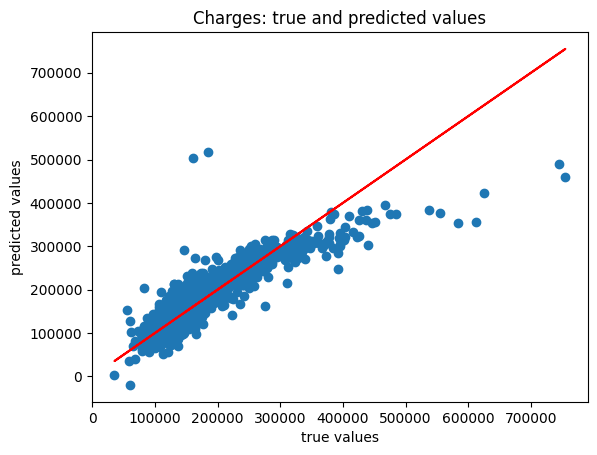

R-Squared of the training is: 0.7630925070514092


In [52]:
lasso_cv=LassoCV(alphas=[0.1,1.0,10.0],cv=5)

lasso_cv.fit(X_train, y_train)

y_train_pred = lasso_cv.predict(X_train)

plt.scatter(y_train, y_train_pred)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-Squared of the training is: {}".format(lasso_cv.score(X_train, y_train)))

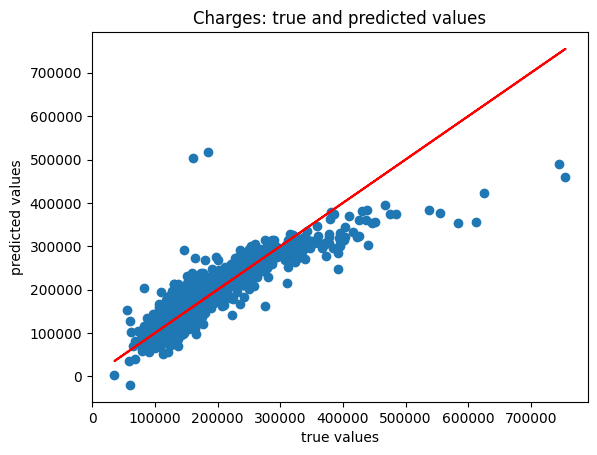

R-Squared of the training is: 0.7630924940567937


In [53]:
ridge_cv=RidgeCV(alphas=[0.1,1.0,10.0],cv=5)

ridge_cv.fit(X_train, y_train)

y_train_pred = ridge_cv.predict(X_train)

plt.scatter(y_train, y_train_pred)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-Squared of the training is: {}".format(ridge_cv.score(X_train, y_train)))

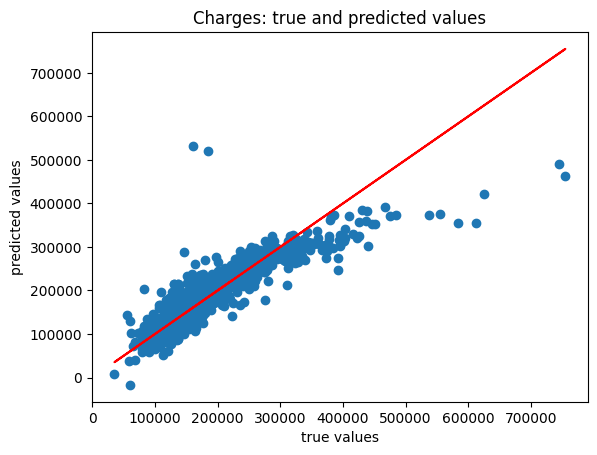

R-Squared of the training is: 0.7615301850764427


In [54]:
elastic_net_cv=ElasticNetCV(alphas=[0.1,1.0,10.0],cv=5)

elastic_net_cv.fit(X_train, y_train)

y_train_pred = elastic_net_cv.predict(X_train)

plt.scatter(y_train, y_train_pred)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-Squared of the training is: {}".format(elastic_net_cv.score(X_train, y_train)))

Ultimately, it appears that OLS did the best for this data set. We will now try it against the test set and see the performance.

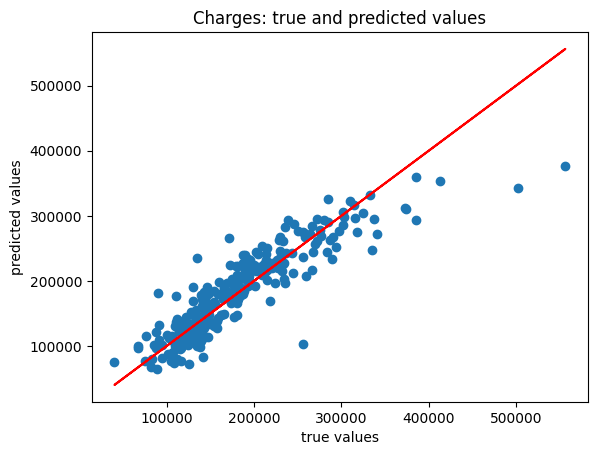

R-Squared of the test is: 0.7630925070938044
Mean absolute error of the prediction is: 23539.129780002877
Mean squared error of the prediction is: 1098265504.761762
Root mean squared error of the prediction is: 33140.089088017885
Mean absolute percentage error of the prediction is: 14.10025301039471


In [55]:
results=sm.OLS(y_train, X_train).fit()

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-Squared of the test is: {}".format(results.rsquared))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The model performs reasonaly well for lower values but definitely diverges in the upper ranges. More work is required to optimize.

For now, we will procced with testing some of the linear regression assumptions to ensure there is no issue there.

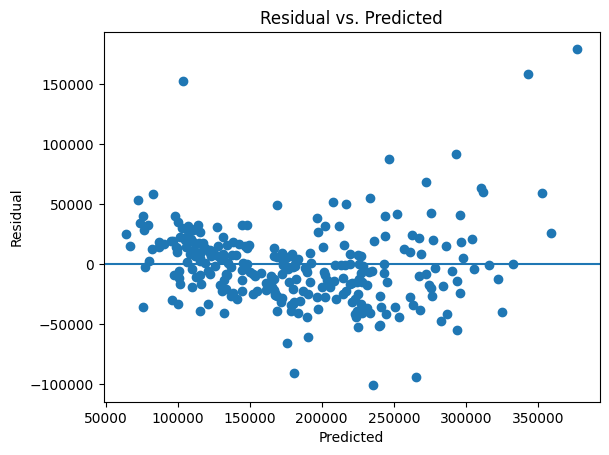

In [56]:
errors=y_test-y_preds

plt.scatter(y_preds, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Errors appear to have consistent variance - i.e. Homoscedasticity seems satisfied

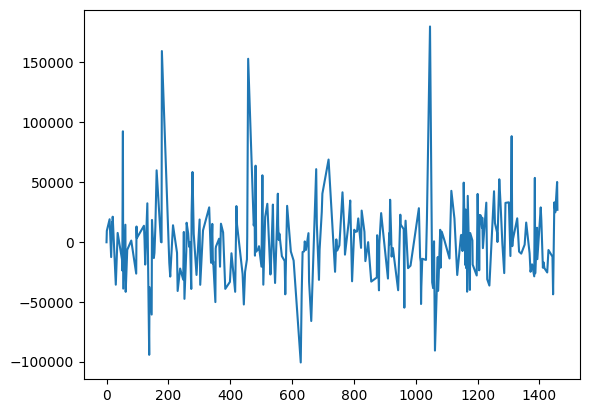

In [57]:
plt.plot(errors)
plt.show()

Error terms also appear uncorrelated

In [58]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 495.5379280668378 and p value is 2.484884078421633e-108
Normality test statistics is 92.99598865856956 and p value is 6.3999656527293e-21


Our errors are not normally distributed. This may indicate that we can trust the statistical significance of our coeeficients and therefore may have elimanted one(s) that could have been useful. It does not, however, invalidate the use of a linear regression model.

Next steps will be to implement more intelligent feature selection as well as to experiment possible with different hyperparamters and models.